## Accessing Schools and highways in London by extracting features from Open Street Maps

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from collections import Counter
from matplotlib.pyplot import pie, axis, show
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext , functions
from pyspark.sql.functions import array_contains,count,countDistinct,col
from folium import plugins



In [3]:
spark = SparkSession.builder \
.appName('ReadFromParquet') \
.master('local[6]') \
.getOrCreate()

In [4]:
spark

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

## Accessing Data Features of OSM : Ways, Nodes and Relations using pySpark

## We have to convert our osm.pbf files into paraquet files which is more spark friendly. 

### https://github.com/adrianulbona/osm-parquetizer


## 1. OSM Way - A way is an ordered list of nodes which normally also has at least one tag or is included within a Relation. A way can have between 2 and 2,000 nodes, although it's possible that faulty ways with zero or a single node exist.

In [6]:
sqlContext.setConf("spark.sql.parquet.binaryAsString","true")
osmWay = sqlContext.read.parquet("./data/london.osm.pbf.way.parquet")
osmWay = osmWay.select('id','tags','nodes')
osmWay.createOrReplaceTempView("osmWay")




In [7]:
osmWay.printSchema()

root
 |-- id: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- nodes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = true)
 |    |    |-- nodeId: long (nullable = true)



# Accessing relations inside which correspond to a tag

In [11]:
# Printing out a a single line to see what the values correspond to.
osmWay.head(1)

[Row(id=73, tags=[Row(key='abutters', value='mixed'), Row(key='highway', value='primary'), Row(key='lit', value='yes'), Row(key='maxspeed', value='30 mph'), Row(key='name', value='Ballards Lane'), Row(key='oneway', value='yes'), Row(key='ref', value='A598'), Row(key='surface', value='asphalt')], nodes=[Row(index=0, nodeId=5849976474), Row(index=1, nodeId=196069)])]

In [13]:
# Nodes corresponding to roads and highways along with the declared speed limit in the area.
# Storing this speed limit for later when we calculate whether a uber driver has been crossing the speed limit.
osmWay.show(5)

+---+--------------------+--------------------+
| id|                tags|               nodes|
+---+--------------------+--------------------+
| 73|[[abutters, mixed...|[[0, 5849976474],...|
| 74|[[abutters, retai...|[[0, 196101], [1,...|
| 75|[[lit, yes], [ref...|[[0, 196055], [1,...|
| 79|[[highway, primar...|[[0, 196108], [1,...|
|482|[[highway, primar...|[[0, 197731], [1,...|
+---+--------------------+--------------------+
only showing top 5 rows



In [12]:
osmWay.count()

343769

## 2. OSM Node - A node is one of the core elements in the OpenStreetMap data model. It consists of a single point in space defined by its latitude, longitude and node id.

In [15]:
osmNode = sqlContext.read.parquet("./data/london.osm.pbf.node.parquet")
osmNode = osmNode.select('tags', 'latitude','longitude')
osmNode.createOrReplaceTempView("osmNode")

In [16]:
osmNode.printSchema()

root
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [17]:
osmNode.head()

Row(tags=[], latitude=51.477948100000006, longitude=-0.0014863)

In [18]:
osmNode.show(5)

+----+------------------+--------------------+
|tags|          latitude|           longitude|
+----+------------------+--------------------+
|  []|51.477948100000006|          -0.0014863|
|  []|51.526976000000005|-0.14579240000000002|
|  []| 51.52435800000001|          -0.1529847|
|  []|        51.5248258|-0.15328170000000002|
|  []|        51.5250847|          -0.1535802|
+----+------------------+--------------------+
only showing top 5 rows



In [19]:
osmNode.count()

4674944

## Using SQL to find schools which correspond to a certain Latitude and longitude 

In [20]:
sqlContext.sql("SELECT tags,latitude, longitude FROM osmNode \
WHERE tags[0].key='amenity' AND tags[0].value='school'").show()

+--------------------+------------------+--------------------+
|                tags|          latitude|           longitude|
+--------------------+------------------+--------------------+
|[[amenity, school...|        51.4007103|          -0.1678725|
|[[amenity, school...|        51.6472902|          -0.1429447|
|[[amenity, school...|51.649935000000006|          -0.1064298|
|[[amenity, school...| 51.65122160000001|          -0.0611936|
|[[amenity, school...|        51.6735643|          -0.0551499|
|[[amenity, school...|        51.5501872|          -0.3354402|
|[[amenity, school...|        51.6564946|          -0.1717862|
|[[amenity, school...|51.553740700000006|-0.34746330000000003|
|[[amenity, school...|        51.3566002|-0.22014820000000002|
|[[amenity, school...|51.643671000000005|          -0.1409598|
|[[amenity, school...|51.670156500000004|-0.17317280000000002|
|[[amenity, school...|51.636574100000004|-0.04387410000000...|
|[[amenity, school...|51.659585400000005|          -0.0

## OSM Relation : A relation is a group of elements. To be more exact it is one of the core data elements that consists of one or more tags and also an ordered list of one or more nodes, ways and/or relations as members which is used to define logical or geographic relationships between other elements.

In [22]:
osmRelation = sqlContext.read.parquet("./data/london.osm.pbf.relation.parquet")
osmRelation = osmRelation.select('id','tags','members')
osmRelation.createOrReplaceTempView("osmRelation")

In [23]:
osmRelation.printSchema()

root
 |-- id: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- members: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- role: string (nullable = true)
 |    |    |-- type: string (nullable = true)



In [24]:
osmRelation.head()

Row(id=152, tags=[Row(key='natural', value='water'), Row(key='type', value='multipolygon')], members=[Row(id=4082762, role='outer', type='Way'), Row(id=8134249, role='inner', type='Way')])

In [25]:
osmRelation.show(5)

+---+--------------------+--------------------+
| id|                tags|             members|
+---+--------------------+--------------------+
|152|[[natural, water]...|[[4082762, outer,...|
|332|[[name, Kingsmere...|[[4300586, outer,...|
|406|[[type, multipoly...|[[156456311, inne...|
|819|[[name, The Lake]...|[[4788818, outer,...|
|962|[[natural, water]...|[[5019768, outer,...|
+---+--------------------+--------------------+
only showing top 5 rows



In [26]:
osmRelation.count()

23366

# Exploring the data found in OSM London.

## Exploring highways and residential areas near schools would help us better understand the data.

### Distribution of Different Type of Highway

In [27]:
highway = sqlContext.sql("SELECT osmWay.tags[0].value as Value,COUNT(osmWay.tags[0].value) as Count FROM osmWay WHERE tags[0].key='highway' GROUP BY osmWay.tags[0].value")
highway.count()

32

In [29]:
# Storing our highway data
data = []
allRows = sqlContext.sql("SELECT id,tags FROM osmWay")
for row in allRows.collect():
    for item in row["tags"]:
        if item.key == "highway":
            data.append(item.value)
counter = Counter(foundDatas)
result = [(counter[key], key) for key in counter]

In [30]:
highwaydf = pd.DataFrame(list(result),columns=['Count','Value'])
highway = highwaydf.sort_values(by=['Count'],ascending=False)

In [31]:
highway = highway.head()
highway

,Count,Value
1,70252,residential
3,65536,footway
4,60396,service
9,14629,cycleway
0,12537,primary


### The greater area of London is largely residential according to OSM data. Most londoners seem to walk to places. In areas where footways are more popular, speed limits are usually lower

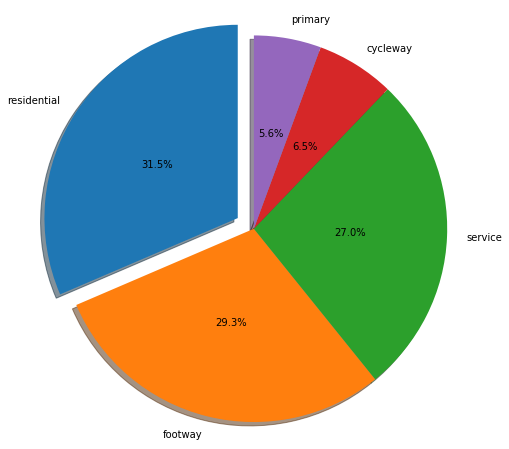

In [33]:
plt.pie(
    highway['Count'],
    labels=highway['Value'],
    shadow=True,
    explode=(0.1, 0, 0, 0, 0),
    startangle=90,
    autopct='%1.1f%%',
    pctdistance = 0.5,
)

plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(8,8)


### Testing out how to find the most common amentities

In [34]:
amenities = sqlContext.sql("SELECT osmWay.tags[0].value as Value,COUNT(osmWay.tags[0].value) as Count FROM osmWay WHERE tags[0].key='amenity' GROUP BY osmWay.tags[0].value")
amenities.count()

136

In [35]:
amenities.show()

+------------------+-----+
|             Value|Count|
+------------------+-----+
|             bench|   68|
|       marketplace|   48|
|       arts_centre|   14|
|   bicycle_parking|   59|
|           college|   43|
|        veterinary|   12|
|           seating|    1|
|        university|   73|
|         nightclub|    8|
|alternative_health|    1|
|             green|    3|
|              shop|    1|
|        car_rental|    6|
|        courthouse|   11|
|       prep_school|    1|
|            prison|    9|
|         education|    1|
|        job_centre|    2|
|       health_club|    1|
|     dressing_room|    1|
+------------------+-----+
only showing top 20 rows



In [36]:
foundDatas = []
allRows = sqlContext.sql("SELECT id,tags FROM osmWay")
for row in allRows.collect():
    for item in row["tags"]:
        if item.key == "amenity":
            foundDatas.append(item.value)
counter = Counter(foundDatas)
result = [(counter[key], key) for key in counter]

In [37]:
# Count the number of columns in the data and sort them accordingly.
amenitydf = pd.DataFrame(list(result),columns=['Count','Value'])
amenity = amenitydf.sort_values(by=['Count'],ascending=False)

In [38]:
amenitiesdf = amenity.sort_values(by=['Count'],ascending=False)
amenitiesdf.head()

,Count,Value
0,7714,parking
4,2945,school
12,2405,restaurant
7,2007,place_of_worship
22,1617,cafe


### The second most common amenity in London is schools with 2945 schools

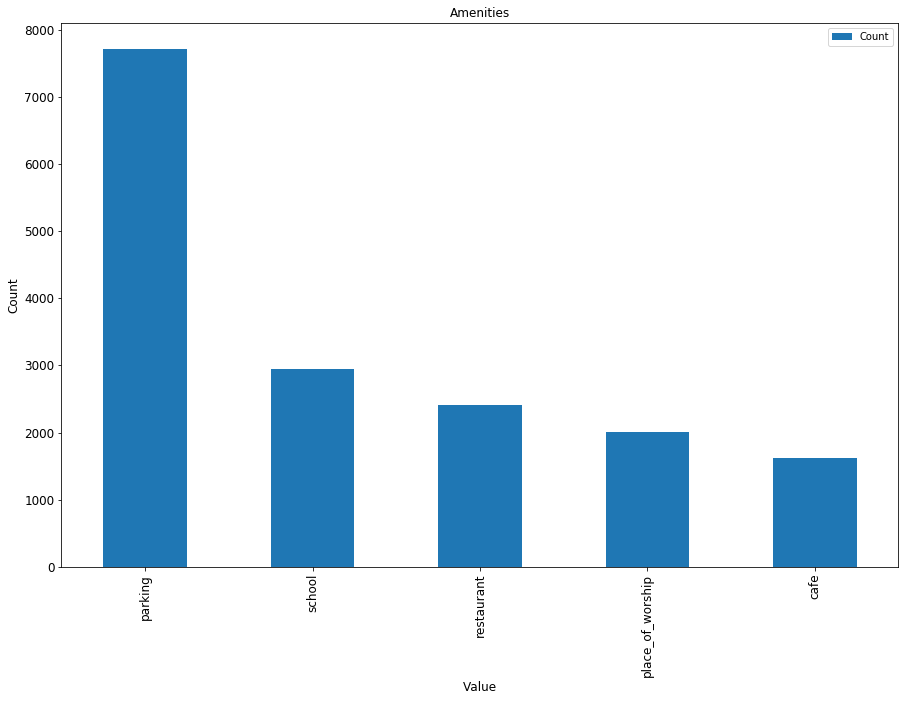

In [39]:
# Plotting a simple bar graph for easy visualization
ax = amenitiesdf[:5].plot(kind='bar',x='Value', y='Count',title ="Amenities", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Value", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

### Finding School Locations across London

In [41]:
schoolLocation = sqlContext.sql("SELECT latitude,longitude FROM osmNode ") \
.where((array_contains(osmNode.tags.value,'school')))

schoolLocation.take(5)


[Row(latitude=51.4007103, longitude=-0.1678725),
 Row(latitude=51.664409000000006, longitude=-0.0888129),
 Row(latitude=51.6472902, longitude=-0.1429447),
 Row(latitude=51.649935000000006, longitude=-0.1064298),
 Row(latitude=51.4494775, longitude=-0.038884)]

In [43]:
#finding school locations and sending it to Pandas for further analysis
schoolLocation = sqlContext.sql("SELECT latitude,longitude FROM osmNode") \
.where((array_contains(osmNode.tags.value,'school'))).toPandas()

In [48]:
schooldf = pd.DataFrame(data=schoolLocation)
schooldf.head()

,latitude,longitude
0,51.400710,-0.167873
1,51.664409,-0.088813
2,51.647290,-0.142945
3,51.649935,-0.106430
4,51.449478,-0.038884


In [58]:
# Saving this file for visualization
export_csv = schooldf.to_csv ('~/documents/london-schools.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path


## Plotting a map of all the schools. Folium makes it really easy to plot and visualize data.
### We are going to use a geospatial visualizing tool like Kepler.gl but folium is a quick and easy way

In [59]:
schoolMap = folium.Map([schoolLocation.latitude[0],
                      schoolLocation.longitude[0]],
                      tiles='Stamen Terrain',
                      zoom_start=10,
                      attr='wtgeographer Mapbox Attribution')


In [54]:
for index, row in schooldf.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=3,
                        popup=row[['latitude','longitude']],
                        fill_color="#ffffff",
                       ).add_to(schoolMap)
    


schoolMap